In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from os.path import basename

import cPickle
import h5py
import yaml

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# matplotlib.rcParams['text.usetex']=False
# matplotlib.rcParams['text.latex.unicode']=True



from matplotlib import cm

def get_colors(number_of_lines):
    start = 0.0
    stop = 1.0
    cm_subsection = np.linspace(start, stop, number_of_lines) 

    colors = [ cm.viridis(x) for x in cm_subsection ]
    colors = colors[::-1]
    return colors



def plot_curves(datadir, exps, plot_train_loss=True, figsize=(10,10), colors=None, linewidth=2):
    fig=plt.figure(figsize=figsize)
    for iexp, exp in enumerate(exps):

        # plot the learning curves
        histfile=datadir + '/history/' + exp['histfile']
        label=exp['label']
        with open(histfile,'rb') as f:
            hist = cPickle.load(f)
        val_loss = hist['on_epoch_end']['val_loss']
        if colors is None:
            p=plt.plot(val_loss, label=label, linewidth=linewidth)
        else:
            p=plt.plot(val_loss, label=label, color=colors[iexp], linewidth=linewidth)
        if plot_train_loss:
            plt.plot(hist['on_epoch_end']['loss'], color=p[0].get_color(), linestyle=':', linewidth=linewidth+1)

        # count the trainable weights of the model
        modelfile = datadir + '/models/' + basename(histfile).replace('history','model') + '.hdf5'
        f = h5py.File(modelfile)
        paramsfile = datadir + '/configs/' + basename(histfile).replace('history', 'params') + '.yaml'
        with open(paramsfile,'rb') as fp:
            params = yaml.load(fp)
        num_params = 0
        for key in f.keys():
            for key2 in f[key]:
                for key3 in f[key][key2].keys():
                    #print f[key][key2][key3]
                    if 'params_trainable' in params.keys():

                        params_trainable = params['params_trainable'] + ['h0']

                        param_is_trainable = False
                        for name in params_trainable:
                            # for each name of the trainable weights
                            if name in key3:
                                # only count these weights as trainable if the parameter is trainable
                                param_is_trainable = True
                                #print "%s is trainable, since it contains %s" % (key3,name)

                        if not param_is_trainable:
                            continue

                    # print "Trainable weight %s has shape %s with size %d" % (key3,f[key][key2][key3].shape,np.prod(f[key][key2][key3].shape))
                    num_params = num_params + np.prod(f[key][key2][key3].shape)

        print "Model '%s' has %d trainable weights, best val_loss is %f" % (label,num_params,min(val_loss))
    return fig

In [50]:
def num_params_LSTM(K_layers, N, data_dim):
    num_params=0
    num_params=num_params + K_layers*4*N
    num_params=num_params + data_dim*4*N
    num_params=num_params + (2*K_layers-1)*4*(N**2)
    num_params=num_params + data_dim
    num_params=num_params + N*data_dim
#     Trainable weight bias has shape (400,) with size 400
#     Trainable weight kernel has shape (257, 400) with size 102800
#     Trainable weight recurrent_kernel has shape (100, 400) with size 40000
#     Trainable weight bias has shape (400,) with size 400
#     Trainable weight kernel has shape (100, 400) with size 40000
#     Trainable weight recurrent_kernel has shape (100, 400) with size 40000
#     Trainable weight bias has shape (400,) with size 400
#     Trainable weight kernel has shape (100, 400) with size 40000
#     Trainable weight recurrent_kernel has shape (100, 400) with size 40000
#     Trainable weight bias has shape (257,) with size 257
#     Trainable weight kernel has shape (100, 257) with size 25700
    return num_params

def num_params_uSNMF(K_layers, N, data_dim):
    num_params=0
    num_params=num_params + K_layers*2*N*data_dim
    num_params=num_params + K_layers
    num_params=num_params + 2*N
#     Trainable weight simple_deep_rnn_1_log_D_0 has shape (257, 200) with size 51400
#     Trainable weight simple_deep_rnn_1_log_D_1 has shape (257, 200) with size 51400
#     Trainable weight simple_deep_rnn_1_log_D_2 has shape (257, 200) with size 51400
#     Trainable weight simple_deep_rnn_1_log_alph_0 has shape () with size 1
#     Trainable weight simple_deep_rnn_1_log_alph_1 has shape () with size 1
#     Trainable weight simple_deep_rnn_1_log_alph_2 has shape () with size 1
#     Trainable weight simple_deep_rnn_1_log_h0 has shape (200,) with size 200
    return num_params

print num_params_LSTM(2, 100, 257)
print num_params_LSTM(3, 100, 257)
print num_params_LSTM(4, 100, 257)

print ""

print num_params_LSTM(2, 54, 257)
print num_params_LSTM(3, 62, 257)
print num_params_LSTM(4, 66, 257)
print num_params_LSTM(5, 70, 257)

print ""

print num_params_uSNMF(2, 100, 257)
print num_params_uSNMF(3, 100, 257)
print num_params_uSNMF(4, 100, 257)
print num_params_uSNMF(5, 100, 257)

print ""

print num_params_LSTM(2, 244, 257)
print num_params_LSTM(5, 250, 257)
print num_params_LSTM(1, 660, 257)

print ""

print num_params_uSNMF(2, 1000, 257)
print num_params_uSNMF(5, 1000, 257)
print num_params_uSNMF(10, 500, 257)

249557
329957
410357

105071
157551
208091
268007

103002
154403
205804
257205

1030181
2576507
2593397

1030002
2572005
2571010


Model 'LSTM, K=2, N=54, Adam, lr=1e-4, clip=1.' has 105071 trainable weights, best val_loss is 0.040835
Model 'LSTM, K=2, N=244, Adam, lr=1e-4, clip=1., pat. 50' has 1030181 trainable weights, best val_loss is 0.033863
Model 'uSNMF, K=2, N=100, Adam, lr=1e-3, clip=0., pat. 50' has 103002 trainable weights, best val_loss is 0.032010
Model 'uSNMF, K=2, N=1000, Adam, lr=1e-3, clip=0., pat. 50, alph=400.' has 1030002 trainable weights, best val_loss is 0.029525


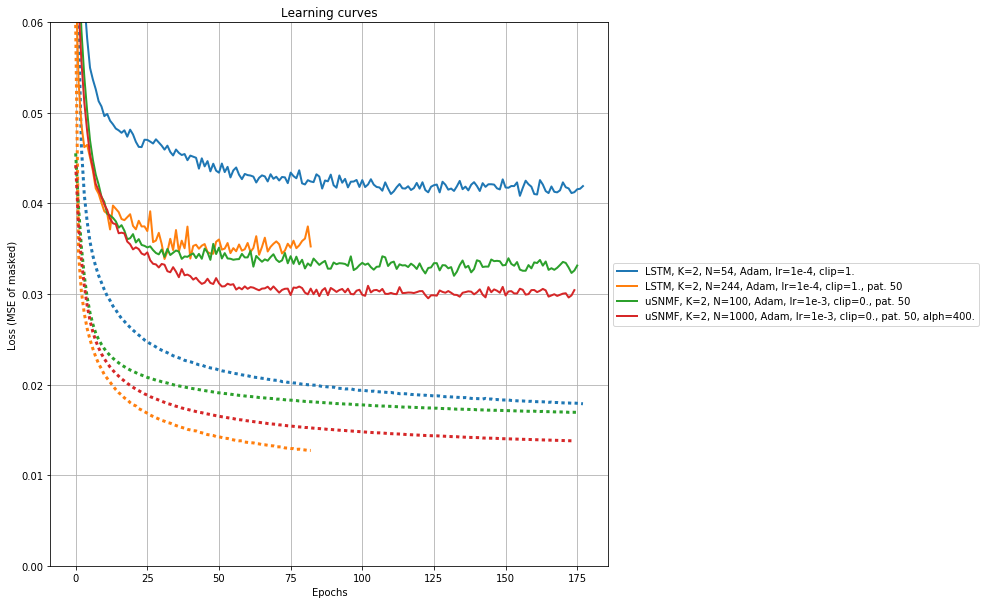

In [42]:
# training data downsampled by 1
datadir='data_setup_cc061d1dc474f44165340bb36f11b16d'

exps=[{'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
       'label': 'LSTM, K=2, N=54, Adam, lr=1e-4, clip=1.'},
      {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
       'label': 'LSTM, K=2, N=244, Adam, lr=1e-4, clip=1., pat. 50'},
      #{'histfile':'history_lstm_9502be29e63a620ee3a1247d239011df',
      # 'label': 'LSTM, K=2, N=244, Adam, lr=1e-5, clip=1., pat. 50'},
      {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
       'label': 'uSNMF, K=2, N=100, Adam, lr=1e-3, clip=0., pat. 50'},
#       {'histfile':'history_unfolded_snmf_af935ccee0d8976aedaa6865a7017afa',
#        'label': 'uSNMF, K=2, N=1000, Adam, lr=1e-3, clip=0., pat. 50'},
      {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
       'label': 'uSNMF, K=2, N=1000, Adam, lr=1e-3, clip=0., pat. 50, alph=400.'}
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[0,50]
# xlim=[50,100]
# xlim=[100,150]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.15]
ylim=[0.0,0.06]
# ylim=[0.02,0.04]

plot_curves(datadir, exps, plot_train_loss=plot_train_loss)    
if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE of masked)')

Model 'LSTM, K=2, N=54, Adam, lr=1e-4, clip=1.' has 105071 trainable weights, best val_loss is 0.051167
Model 'LSTM, K=2, N=244, Adam, lr=1e-4, clip=1.' has 1030181 trainable weights, best val_loss is 0.048116
Model 'uSNMF, K=2, N=100, Adam, lr=1e-3, clip=0., pat. 50' has 103002 trainable weights, best val_loss is 0.036235
Model 'uSNMF, K=2, N=1000, Adam, lr=1e-3, clip-0., pat. 50' has 1030002 trainable weights, best val_loss is 0.035428


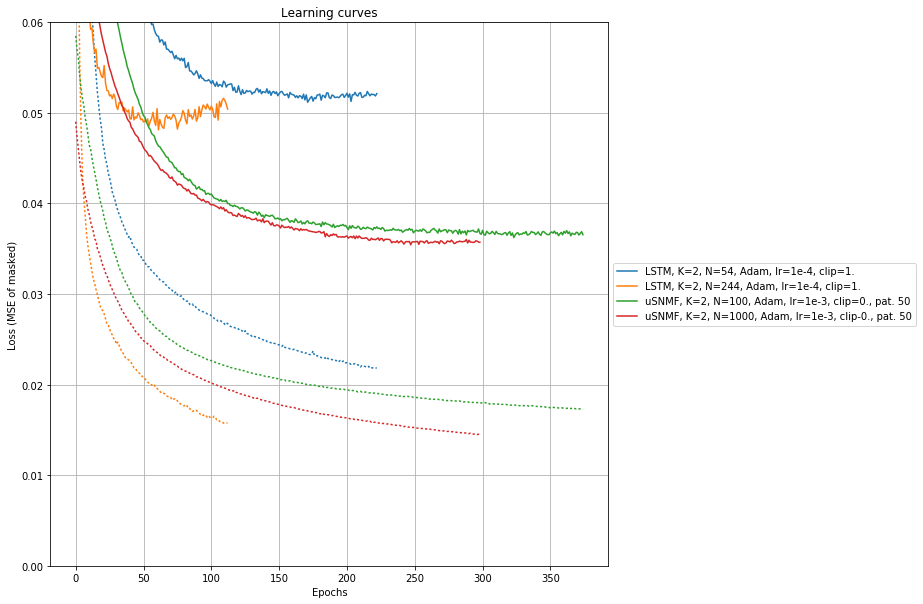

In [230]:
# training data downsampled by 10
datadir='data_setup_db3355248efc7ce949ff0bc5206f0a81'

exps=[{'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
       'label': 'LSTM, K=2, N=54, Adam, lr=1e-4, clip=1.'},
      {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
       'label': 'LSTM, K=2, N=244, Adam, lr=1e-4, clip=1.'},
      #{'histfile':'history_unfolded_snmf_f3174ec281f6b17d2f4eee24e4fed5d5',
      # 'label': 'uSNMF, K=2, N=100, Adam, lr=5e-4, clip=0., pat. 50'},
      {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
       'label': 'uSNMF, K=2, N=100, Adam, lr=1e-3, clip=0., pat. 50'},
      {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
       'label': 'uSNMF, K=2, N=1000, Adam, lr=1e-3, clip-0., pat. 50'}
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[0,50]
# xlim=[50,100]
# xlim=[150,300]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.15]
ylim=[0.0,0.06]
# ylim=[0.0,0.05]

plot_curves(datadir, exps, plot_train_loss=plot_train_loss)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE of masked)')

Model 'LSTM, K=3, N=100, Adam, lr=1e-4, clip=1.' has 329957 trainable weights, best val_loss is 0.060080
Model 'LSTM, K=3, N=62, Adam, lr=1e-4, clip=1.' has 157551 trainable weights, best val_loss is 0.050377
Model 'uSNMF, K=3, N=100, Adam, lr=5e-4, clip=0.' has 154403 trainable weights, best val_loss is 0.037785
Model 'uSNMF pretrain, K=3, N=100, Adam, lr=5e-4, clip=0.' has 154403 trainable weights, best val_loss is 0.040613
Model 'uSNMF, K=3, N=100, Adam, lr=1e-3, clip=0.' has 154403 trainable weights, best val_loss is 0.037847
Model 'uSNMF, K=3, N=100, Adam, lr=1e-3, clip=0., decay=2e-4' has 154403 trainable weights, best val_loss is 0.038250
Model 'uSNMF pretrain, K=3, N=100, Adam, lr=1e-3, clip=0.' has 154403 trainable weights, best val_loss is 0.043010


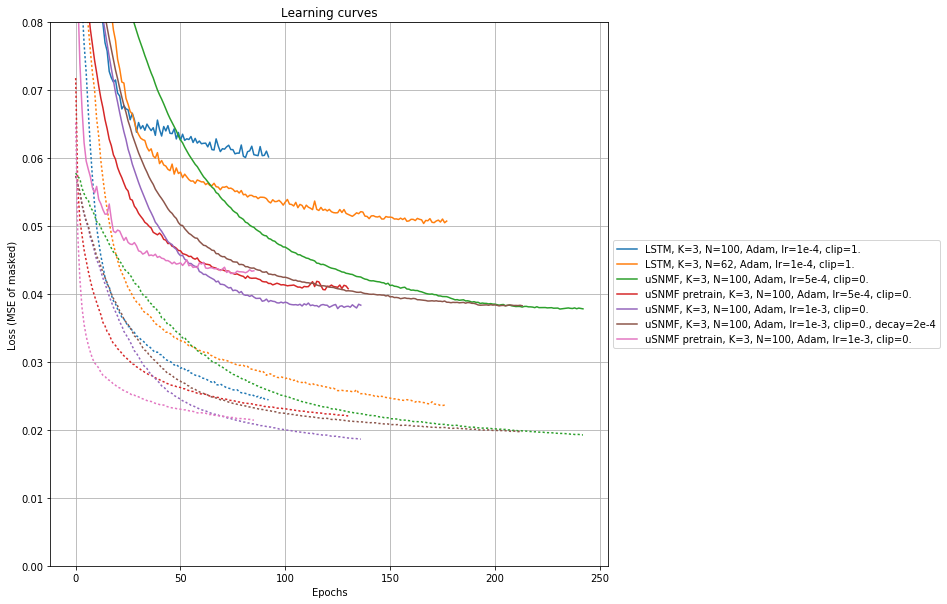

In [197]:
# training data downsampled by 10
datadir='data_setup_db3355248efc7ce949ff0bc5206f0a81'

exps=[{'histfile':'history_lstm_18cf0ccb5b10e338d7e287730fe64db6',
       'label': 'LSTM, K=3, N=100, Adam, lr=1e-4, clip=1.'},
      #{'histfile':'history_lstm_c1369248c05cb8856e57be4f08552fd6',
      # 'label': 'LSTM, K=3, N=100, Adam, lr=1e-4, clip=0.'},
      #{'histfile':'history_lstm_be3959c76ec55712bb9e59de4dbcbecf',
      # 'label': 'LSTM, K=3, N=50, Adam, lr=1e-4, clip=1.'},
      {'histfile':'history_lstm_8d2bb4f9ede9f600d52e7289076e4490',
       'label': 'LSTM, K=3, N=62, Adam, lr=1e-4, clip=1.'},
      #{'histfile':'history_unfolded_snmf_65d98ab57a60e5af6628509c533ca5d6',
      # 'label': 'uSNMF, K=3, Adam, lr=1e-4, clip=1.'},
      #{'histfile':'history_unfolded_snmf_746fb1c3e7ba5f17acd05f6201c58bf1',
      # 'label': 'uSNMF, K=3, N=100, Adam, lr=1e-4, clip=0.'},
      #{'histfile':'history_unfolded_snmf_bf2aef8c0dde7ae71fa8895743d74751',
      # 'label': 'uSNMF, K=3, N=100, Adam, lr=3e-4, clip=0.'},
      #{'histfile':'bkup_history_unfolded_snmf_f15470a9012c589161e79a746bc4ffa8',
      # 'label': 'uSNMF, K=3, N=100, Adam, lr=5e-4, clip=0. (before fix)'},
      {'histfile':'history_unfolded_snmf_f15470a9012c589161e79a746bc4ffa8',
       'label': 'uSNMF, K=3, N=100, Adam, lr=5e-4, clip=0.'},
      {'histfile':'history_unfolded_snmf_0de1886e3cd717bd9947fbf8b7a3ea52',
       'label': 'uSNMF pretrain, K=3, N=100, Adam, lr=5e-4, clip=0.'},
      #{'histfile':'bkup_history_unfolded_snmf_df4f7fae0c930c8f690a35609a9823a9',
      #'label': 'uSNMF, K=3, N=100, Adam, lr=1e-3, clip=0. (before fix)'},
      {'histfile':'history_unfolded_snmf_df4f7fae0c930c8f690a35609a9823a9',
      'label': 'uSNMF, K=3, N=100, Adam, lr=1e-3, clip=0.'},
      #{'histfile':'history_unfolded_snmf_39f9b21235ebbcc6da8c15b1d39d8c90',
      #'label': 'uSNMF, K=3, N=100, Adam, lr=1e-3, clip=0., decay=0.1'},
      {'histfile':'history_unfolded_snmf_fd7863500d25d743f92e28b4fc4f9158',
      'label': 'uSNMF, K=3, N=100, Adam, lr=1e-3, clip=0., decay=2e-4'},
      {'histfile':'history_unfolded_snmf_4bd298ef3d8350004de44931a0060aba',
       'label': 'uSNMF pretrain, K=3, N=100, Adam, lr=1e-3, clip=0.'},
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[0,50]
# xlim=[50,100]
# xlim=[100,150]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.08]
# ylim=[0.0,0.08]
# ylim=[0.03,0.05]

plot_curves(datadir, exps, plot_train_loss=plot_train_loss)

# plt.figure(figsize=(10,10))
# for exp in exps:
    
#     # plot the learning curves
#     histfile='history/' + exp['histfile']
#     label=exp['label']
#     with open(histfile,'rb') as f:
#         hist = cPickle.load(f)
#     val_loss = hist['on_epoch_end']['val_loss']
#     p=plt.plot(val_loss, label=label)
#     if plot_train_loss:
#         plt.plot(hist['on_epoch_end']['loss'], color=p[0].get_color(), linestyle=':')

#     # count the trainable weights of the model
#     modelfile = 'models/' + basename(histfile).replace('history','model') + '.hdf5'
#     f = h5py.File(modelfile)
#     paramsfile = 'configs/' + basename(histfile).replace('history', 'params') + '.yaml'
#     with open(paramsfile,'rb') as fp:
#         params = yaml.load(fp)
#     num_params = 0
#     for key in f.keys():
#         for key2 in f[key]:
#             for key3 in f[key][key2].keys():
#                 #print f[key][key2][key3]
#                 if 'params_trainable' in params.keys():
                    
#                     params_trainable = params['params_trainable'] + ['h0']
                    
#                     param_is_trainable = False
#                     for name in params_trainable:
#                         # for each name of the trainable weights
#                         if name in key3:
#                             # only count these weights as trainable if the parameter is trainable
#                             param_is_trainable = True
#                             #print "%s is trainable, since it contains %s" % (key3,name)
                            
#                     if not param_is_trainable:
#                         continue
                        
#                 # print "Trainable weight %s has shape %s with size %d" % (key3,f[key][key2][key3].shape,np.prod(f[key][key2][key3].shape))
#                 num_params = num_params + np.prod(f[key][key2][key3].shape)
    
#     print "Model '%s' has %d trainable weights, best val_loss is %f" % (label,num_params,min(val_loss))
    
if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE of masked)')

Model 'LSTM, K=4, N=66, Adam, lr=5e-5, clip=1.' has 208091 trainable weights, best val_loss is 0.060075
Model 'LSTM, K=4, N=66, Adam, lr=1e-4, clip=1.' has 208091 trainable weights, best val_loss is 0.055814
Model 'uSNMF, K=4, N=100, Adam, lr=5e-4, clip=0.' has 205804 trainable weights, best val_loss is 0.036057
Model 'uSNMF, K=4, N=100, Adam, lr=1e-3, clip=0.' has 205804 trainable weights, best val_loss is 0.035851
Model 'uSNMF, K=4, N=100, Adam, lr=1e-3, clip=0., patience 50' has 205804 trainable weights, best val_loss is 0.034090


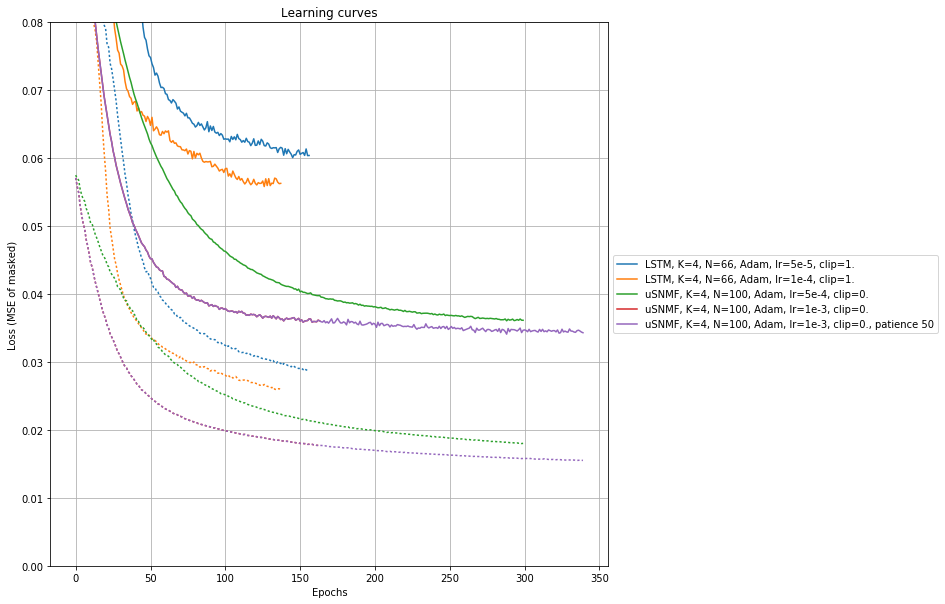

In [281]:
# training data downsampled by 10
datadir='data_setup_db3355248efc7ce949ff0bc5206f0a81'

exps=[
      {'histfile':'history_lstm_9a935dd011b6d6c8603cc3b92c9489e3',
       'label': 'LSTM, K=4, N=66, Adam, lr=5e-5, clip=1.'},
      {'histfile':'history_lstm_ab35655f6cc818207c48c4133b672ad5',
       'label': 'LSTM, K=4, N=66, Adam, lr=1e-4, clip=1.'},
      {'histfile':'history_unfolded_snmf_4d87d0c1c6c7639d4e4d37d289ad21e2',
       'label': 'uSNMF, K=4, N=100, Adam, lr=5e-4, clip=0.'},
      {'histfile':'history_unfolded_snmf_3f8767ae499972d16058e0e4e551bdde',
       'label': 'uSNMF, K=4, N=100, Adam, lr=1e-3, clip=0.'},
      {'histfile':'history_unfolded_snmf_58f3015d334a631ce506dac892659612',
       'label': 'uSNMF, K=4, N=100, Adam, lr=1e-3, clip=0., patience 50'},
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[0,50]
# xlim=[50,100]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.08]
# ylim=[0.05,0.07]
# ylim=[0.03,0.05]

plot_curves(datadir, exps, plot_train_loss=plot_train_loss)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE of masked)')

Model 'LSTM, K=5, N=70' has 268007 trainable weights, best val_loss is 0.042590
Model 'LSTM, K=5, N=250' has 2576507 trainable weights, best val_loss is 0.034364
Model 'DR-SNMF, K=5, N=100' has 257205 trainable weights, best val_loss is 0.028558
Model 'DR-SNMF, K=5, N=1000' has 2572005 trainable weights, best val_loss is 0.026513


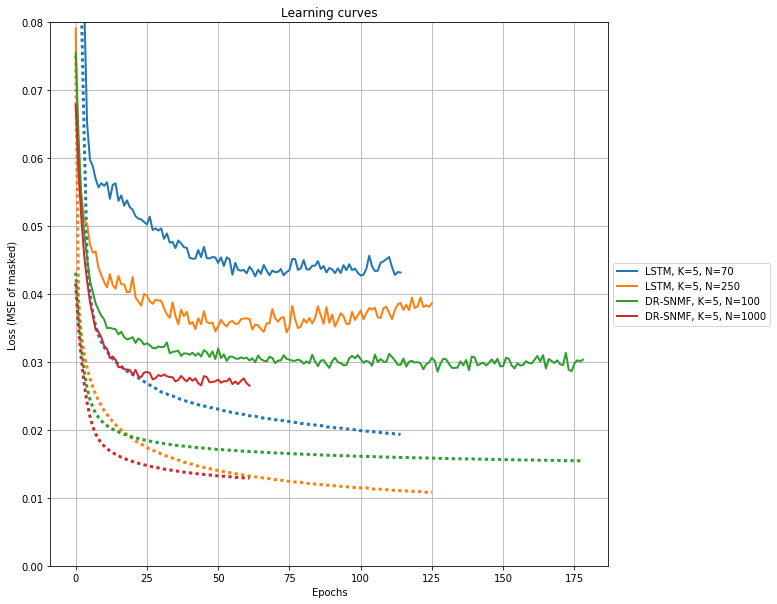

In [54]:
# training data downsampled by 1
datadir='data_setup_cc061d1dc474f44165340bb36f11b16d'

# exps=[
#       {'histfile':'history_lstm_4561bd13e267026c3f3d1c936b15f709',
#        'label': 'uSNMF, K=5, N=250, Adam, lr=1e-3, clip=0., patience 50'},
#       {'histfile':'history_unfolded_snmf_364ccd17a3e187bcccd30cfaa6bd9422',
#        'label': 'uSNMF, K=5, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs'}
#      ]

exps=[ \
#       {'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
#        'label': 'LSTM, K=2, N=54'},
#       {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
#        'label': 'LSTM, K=2, N=244'},
      {'histfile':'history_lstm_6a4fc9017283c9f89380f765a60087ce',
       'label': 'LSTM, K=5, N=70'},
      {'histfile':'history_lstm_4561bd13e267026c3f3d1c936b15f709',
       'label': 'LSTM, K=5, N=250'},
#       {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
#        'label': 'DR-SNMF, K=2, N=100'},
#       {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
#        'label': 'DR-SNMF, K=2, N=1000'},
      {'histfile':'history_unfolded_snmf_ea1e7d485421e527486476ef696da2da',
       'label': 'DR-SNMF, K=5, N=100'},
      {'histfile':'history_unfolded_snmf_364ccd17a3e187bcccd30cfaa6bd9422',
       'label': 'DR-SNMF, K=5, N=1000'}
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[0,100]
# xlim=[25,100]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.08]
# ylim=[0.03,0.05]
# ylim=[0.,0.05]

plot_curves(datadir, exps, plot_train_loss=plot_train_loss)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE of masked)')

Model 'LSTM, K=5, N=70, Adam, lr=1e-4, clip=1., patience 50' has 268007 trainable weights, best val_loss is 0.054158
Model 'LSTM, K=5, N=250, Adam, lr=1e-4, clip=1., patience 50' has 2576507 trainable weights, best val_loss is 0.056552
Model 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs' has 257205 trainable weights, best val_loss is 0.033210
Model 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs, irm squared' has 257205 trainable weights, best val_loss is 0.034091
Model 'uSNMF, K=5, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs' has 2572005 trainable weights, best val_loss is 0.031583
Model 'uSNMF, K=10, N=500, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs' has 2571010 trainable weights, best val_loss is 0.036416
Model 'uSNMF, K=10, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs' has 5142010 trainable weights, best val_loss is 0.064852
Model 'uSNMF, K=5, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs, tied we

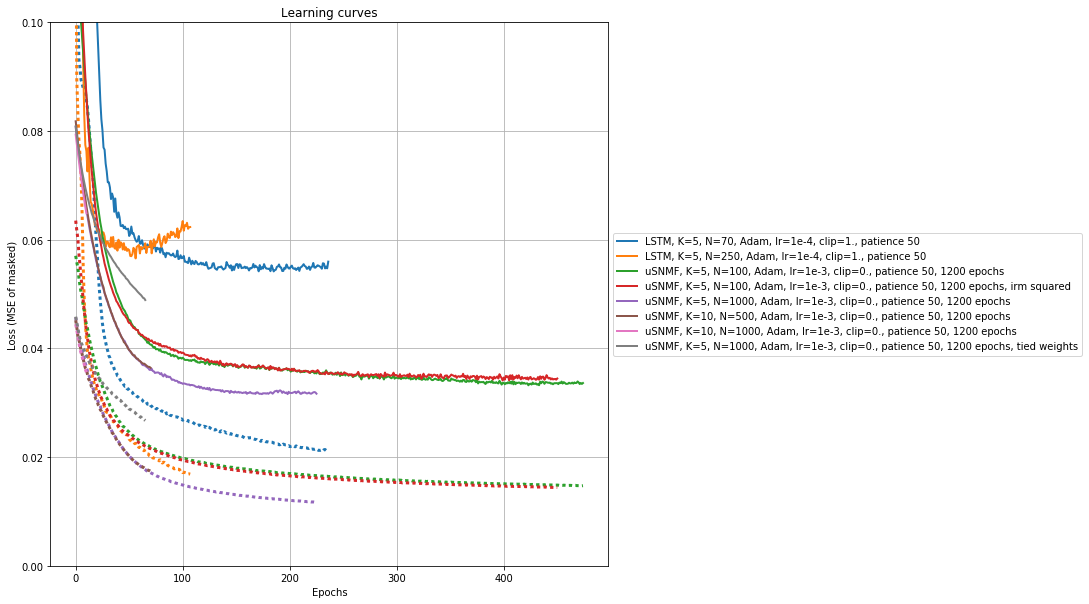

In [45]:
# training data downsampled by 10
datadir='data_setup_db3355248efc7ce949ff0bc5206f0a81'

exps=[
      #{'histfile':'history_lstm_957fd4d2a67ccaa301fae92874891287',
      # 'label': 'LSTM, K=5, N=70, Adam, lr=1e-4, clip=1.'},
      {'histfile':'history_lstm_6a4fc9017283c9f89380f765a60087ce',
       'label': 'LSTM, K=5, N=70, Adam, lr=1e-4, clip=1., patience 50'},
      {'histfile':'history_lstm_4561bd13e267026c3f3d1c936b15f709',
       'label': 'LSTM, K=5, N=250, Adam, lr=1e-4, clip=1., patience 50'},
      #{'histfile':'history_unfolded_snmf_54eb5e0280b67d457194aac695621112',
      # 'label': 'uSNMF, K=5, N=100, Adam, lr=5e-4, clip=0.'},
      #{'histfile':'history_unfolded_snmf_672be0ed41cd183d850651d0717246d4',
      # 'label': 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0.'},
      #{'histfile':'history_unfolded_snmf_2767a99603c236107da44c5c2083df31',
      # 'label': 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., patience 50'},
      #{'histfile':'history_unfolded_snmf_74fac20a267dfa5d108dc35f926b3354',
      # 'label': 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., patience 50, continued'},
      {'histfile':'history_unfolded_snmf_ea1e7d485421e527486476ef696da2da',
       'label': 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs'},
      #{'histfile':'history_unfolded_snmf_fc7002f6602d892c9d3a7c29b074e9e1',
      # 'label': 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., tied D'}
      #{'histfile':'history_unfolded_snmf_b358ef2a02b8d019bc42aa01cfd65aff',
      # 'label': 'uSNMF, K=5, N=100, Adam, lr=1e-4, clip=0., tied D'}
      {'histfile':'history_unfolded_snmf_87276812786ea59856cca83cbd5753fb',
       'label': 'uSNMF, K=5, N=100, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs, irm squared'},
      {'histfile':'history_unfolded_snmf_364ccd17a3e187bcccd30cfaa6bd9422',
       'label': 'uSNMF, K=5, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs'},
      {'histfile':'history_unfolded_snmf_0c69c9d9e82d21afa7ec4043e6e70c76',
       'label':'uSNMF, K=10, N=500, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs'},
      {'histfile':'history_unfolded_snmf_0adebc571e6123cc479ee39e4f489772',
       'label':'uSNMF, K=10, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs'},
      {'histfile':'history_unfolded_snmf_4fe72fa6c7542e5eacb7242bc4880687',
       'label':'uSNMF, K=5, N=1000, Adam, lr=1e-3, clip=0., patience 50, 1200 epochs, tied weights'},
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[0,50]
# xlim=[100,200]
# xlim=[300,350]
ylim=None
# ylim=[0.0,0.15]
ylim=[0,0.1]
# ylim=[0.,0.05]

plot_curves(datadir, exps, plot_train_loss=plot_train_loss)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE of masked)')

Model 'LSTM, K=2, N=54' has 105071 trainable weights, best val_loss is 0.051167
Model 'LSTM, K=2, N=244' has 1030181 trainable weights, best val_loss is 0.048116
Model 'DR-SNMF, K=2, N=100' has 103002 trainable weights, best val_loss is 0.036235
Model 'DR-SNMF, K=2, N=1000' has 1030002 trainable weights, best val_loss is 0.035428


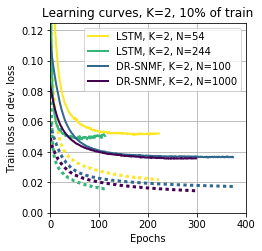

In [26]:
# training data downsampled by 10
datadir='data_setup_db3355248efc7ce949ff0bc5206f0a81'

fig_name='figures/learning_curves_K2_ds10_3-5x3-5.pdf'

exps=[ \
      {'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
       'label': 'LSTM, K=2, N=54'},
      {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
       'label': 'LSTM, K=2, N=244'},
#       {'histfile':'history_lstm_6a4fc9017283c9f89380f765a60087ce',
#        'label': 'LSTM, K=5, N=70'},
#       {'histfile':'history_lstm_4561bd13e267026c3f3d1c936b15f709',
#        'label': 'LSTM, K=5, N=250'},
      {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
       'label': 'DR-SNMF, K=2, N=100'},
      {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
       'label': 'DR-SNMF, K=2, N=1000'},
#       {'histfile':'history_unfolded_snmf_ea1e7d485421e527486476ef696da2da',
#        'label': 'DR-SNMF, K=5, N=100'},
#       {'histfile':'history_unfolded_snmf_364ccd17a3e187bcccd30cfaa6bd9422',
#        'label': 'DR-SNMF, K=5, N=1000'}
     ]

colors=get_colors(4)

only_big_models=True
only_big_models=False
if only_big_models:
    exps=[exps[1],exps[3]]
    colors=get_colors(2)

plot_train_loss = False
plot_train_loss = True
xlim=None
xlim=[0,400]
# xlim=[100,200]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.125]
# ylim=[0.03,0.04]
# ylim=[0.,0.05]

fig=plot_curves(datadir, exps, plot_train_loss=plot_train_loss, figsize=(3.5,3.5), colors=colors)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves, K=2, 10% of train')
plt.legend()#loc='center left')#, bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Train loss or dev. loss')

fig.savefig(fig_name, bbox_inches='tight')

Model 'LSTM, K=5, N=70' has 268007 trainable weights, best val_loss is 0.054158
Model 'LSTM, K=5, N=250' has 2576507 trainable weights, best val_loss is 0.056552
Model 'DR-SNMF, K=5, N=100' has 257205 trainable weights, best val_loss is 0.033210
Model 'DR-SNMF, K=5, N=1000' has 2572005 trainable weights, best val_loss is 0.031583


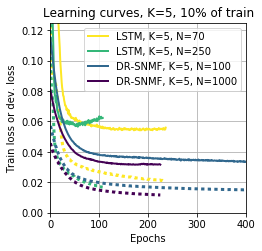

In [27]:
# training data downsampled by 10
datadir='data_setup_db3355248efc7ce949ff0bc5206f0a81'

fig_name='figures/learning_curves_K5_ds10_3-5x3-5.pdf'

exps=[ \
#       {'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
#        'label': 'LSTM, K=2, N=54'},
#       {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
#        'label': 'LSTM, K=2, N=244'},
      {'histfile':'history_lstm_6a4fc9017283c9f89380f765a60087ce',
       'label': 'LSTM, K=5, N=70'},
      {'histfile':'history_lstm_4561bd13e267026c3f3d1c936b15f709',
       'label': 'LSTM, K=5, N=250'},
#       {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
#        'label': 'DR-SNMF, K=2, N=100'},
#       {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
#        'label': 'DR-SNMF, K=2, N=1000'},
      {'histfile':'history_unfolded_snmf_ea1e7d485421e527486476ef696da2da',
       'label': 'DR-SNMF, K=5, N=100'},
      {'histfile':'history_unfolded_snmf_364ccd17a3e187bcccd30cfaa6bd9422',
       'label': 'DR-SNMF, K=5, N=1000'}
     ]

colors=get_colors(4)

only_big_models=True
only_big_models=False
if only_big_models:
    exps=[exps[1],exps[3]]
    colors=get_colors(2)

plot_train_loss = False
plot_train_loss = True
xlim=None
xlim=[0,400]
# xlim=[100,200]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.125]
# ylim=[0.03,0.04]
# ylim=[0.,0.05]

fig=plot_curves(datadir, exps, plot_train_loss=plot_train_loss, figsize=(3.5,3.5), colors=colors)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves, K=5, 10% of train')
plt.legend()#loc='center left')#, bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Train loss or dev. loss')

fig.savefig(fig_name, bbox_inches='tight')

Model 'LSTM, K=2, N=54' has 105071 trainable weights, best val_loss is 0.040835
Model 'LSTM, K=2, N=244' has 1030181 trainable weights, best val_loss is 0.033863
Model 'uSNMF, K=2, N=100' has 103002 trainable weights, best val_loss is 0.032010
Model 'uSNMF, K=2, N=1000' has 1030002 trainable weights, best val_loss is 0.029525


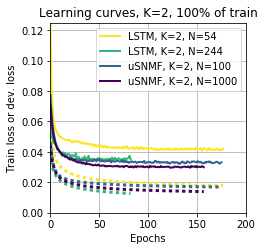

In [28]:
# training data downsampled by 1, K=2
datadir='data_setup_cc061d1dc474f44165340bb36f11b16d'

fig_name='figures/learning_curves_K2_ds1_3-5x3-5.pdf'

exps=[{'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
       'label': 'LSTM, K=2, N=54'},
      {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
       'label': 'LSTM, K=2, N=244'},
      {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
       'label': 'uSNMF, K=2, N=100'},
      {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
       'label': 'uSNMF, K=2, N=1000'}
     ]

colors=get_colors(4)

only_big_models=True
only_big_models=False
if only_big_models:
    exps=[exps[1],exps[3]]
    colors=get_colors(2)

plot_train_loss = False
plot_train_loss = True
xlim=None
xlim=[0,200]
# xlim=[100,200]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.125]
# ylim=[0.03,0.04]
# ylim=[0.,0.05]

fig=plot_curves(datadir, exps, plot_train_loss=plot_train_loss, figsize=(3.5,3.5), colors=colors)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves, K=2, 100% of train')
plt.legend()#loc='center left')#, bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Train loss or dev. loss')

fig.savefig(fig_name, bbox_inches='tight')

Model 'LSTM, K=5, N=70' has 268007 trainable weights, best val_loss is 0.046747
Model 'LSTM, K=5, N=250' has 2576507 trainable weights, best val_loss is 0.034364
Model 'DR-SNMF, K=5, N=100' has 257205 trainable weights, best val_loss is 0.030146
Model 'DR-SNMF, K=5, N=1000' has 2572005 trainable weights, best val_loss is 0.027142


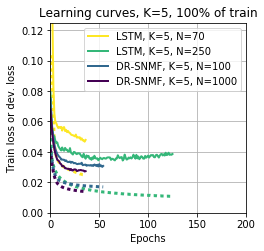

In [29]:
# training data downsampled by 1
datadir='data_setup_cc061d1dc474f44165340bb36f11b16d'

fig_name='figures/learning_curves_K5_ds1_3-5x3-5.pdf'

exps=[ \
#       {'histfile':'history_lstm_46666e232751074bd609167dc440df8c',
#        'label': 'LSTM, K=2, N=54'},
#       {'histfile':'history_lstm_b6da76df68cf530d091aa499d61143de',
#        'label': 'LSTM, K=2, N=244'},
      {'histfile':'history_lstm_6a4fc9017283c9f89380f765a60087ce',
       'label': 'LSTM, K=5, N=70'},
      {'histfile':'history_lstm_4561bd13e267026c3f3d1c936b15f709',
       'label': 'LSTM, K=5, N=250'},
#       {'histfile':'history_unfolded_snmf_a45e86a1cc146e1e9d7a7f8100d9d2d7',
#        'label': 'DR-SNMF, K=2, N=100'},
#       {'histfile':'history_unfolded_snmf_a23657edf96a44331501d773db837a1c',
#        'label': 'DR-SNMF, K=2, N=1000'},
      {'histfile':'history_unfolded_snmf_ea1e7d485421e527486476ef696da2da',
       'label': 'DR-SNMF, K=5, N=100'},
      {'histfile':'history_unfolded_snmf_364ccd17a3e187bcccd30cfaa6bd9422',
       'label': 'DR-SNMF, K=5, N=1000'}
     ]

colors=get_colors(4)

only_big_models=False
if only_big_models:
    exps=[exps[1],exps[3]]
    colors=get_colors(2)

plot_train_loss = False
plot_train_loss = True
xlim=None
xlim=[0,200]
# xlim=[100,200]
# xlim=[300,350]
ylim=None
ylim=[0.0,0.125]
# ylim=[0.03,0.04]
# ylim=[0.,0.05]

fig=plot_curves(datadir, exps, plot_train_loss=plot_train_loss, figsize=(3.5,3.5), colors=colors)

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves, K=5, 100% of train')
plt.legend()#loc='center left')#, bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Train loss or dev. loss')

fig.savefig(fig_name, bbox_inches='tight')

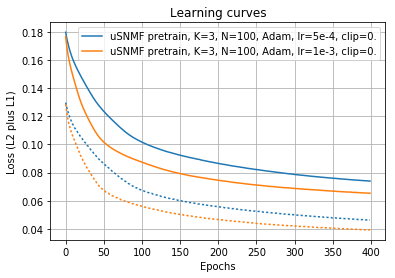

In [17]:

exps=[{'histfile':'history_unfolded_snmf_0de1886e3cd717bd9947fbf8b7a3ea52_pretrain',
       'label': 'uSNMF pretrain, K=3, N=100, Adam, lr=5e-4, clip=0.'},
      {'histfile':'history_unfolded_snmf_4bd298ef3d8350004de44931a0060aba_pretrain',
       'label': 'uSNMF pretrain, K=3, N=100, Adam, lr=1e-3, clip=0.'}
     ]

plot_train_loss = False
plot_train_loss = True
xlim=None
# xlim=[50,100]
# xlim=[300,350]
ylim=None
# ylim=[0.0,0.08]

for exp in exps:
    
    # plot the learning curves
    histfile='history/' + exp['histfile']
    label=exp['label']
    with open(histfile,'rb') as f:
        hist = cPickle.load(f)
    val_loss = hist['on_epoch_end']['val_loss']
    p=plt.plot(val_loss, label=label)
    if plot_train_loss:
        plt.plot(hist['on_epoch_end']['loss'], color=p[0].get_color(), linestyle=':')

if xlim is not None:
    plt.xlim(xlim)
if ylim is not None:
    plt.ylim(ylim)
plt.title('Learning curves')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss (L2 plus L1)')